In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import itertools
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
def load_data():
    import os
    import pickle

    dataset_file = "mnist_dataset.pkl"

    if os.path.exists(dataset_file):
        print(f"Loading dataset from {dataset_file}")
        with open(dataset_file, 'rb') as f:
            data = pickle.load(f)
            X, y = data["data"], data["target"]
    
    else:
        print("Dataset not found, downloading it")
        mnist = fetch_openml('mnist_784', as_frame=False)
        X, y = mnist.data, mnist.target
        
        print(f"Saving dataset to {dataset_file}")
        with open(dataset_file, 'wb') as f:
            pickle.dump({"data": X, "target": mnist.target}, f)

    y = y.astype(np.uint8)
    return X, y
    
        

In [3]:
def evaluate_model(params):
    n_estimators, max_depth, min_samples_split, criterion, X_train, y_train, X_val, y_val = params

    model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        criterion = criterion,
        random_state = 42,
        n_jobs = 1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Evaluated: n_estimators = {n_estimators}, max_depth = {max_depth}, min_samples_split = {min_samples_split}, criterion = {criterion}, accuracy = {accuracy}")

    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "accuracy": accuracy
    }

In [4]:
def run_grid_search(n_procesors, params_list):
    start_time = time.time()
    if n_procesors == 1:
        results = []
        for params in params_list:
            results.append(evaluate_model(params))
    else:
        with Pool(n_procesors) as pool:
            results = pool.map(evaluate_model, params_list)
    end_time = time.time()
    execution_time = end_time - start_time
    
    best_params = max(results, key=lambda x: x['accuracy'])
    print(f"Best parameters with {n_procesors} processors: {best_params}")
    print(f"Time taken with {n_procesors} processors: {execution_time:.2f} seconds")
    
    return execution_time, best_params
    

In [ ]:
X, y = load_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [10, 30],
    'max_depth': [5, 10],
    'min_samples_split': [2, 4],
    'criterion': ['gini', 'entropy', 'log_loss']
}

param_combinations = list(itertools.product(
    params['n_estimators'],
    params['max_depth'],
    params['min_samples_split'],
    params['criterion']
))

print(f"Total combinations: {len(param_combinations)}")

params_list = [(n_estimators, max_depth, min_samples_split, criterion, X_train, y_train, X_val, y_val) 
              for n_estimators, max_depth, min_samples_split, criterion in param_combinations]

results_data = {
    'n_procesors': [],
    'execution_time': [],
    'speedup': [],
    'efficiency': []
}

Loading dataset from mnist_dataset.pkl
Total combinations: 24


In [8]:
max_processors = cpu_count()
processor_counts = [1, 2, 4, 8, max_processors - 1] 
processor_counts = [p for p in processor_counts if p <= max_processors]
print(f"Maximum available processors: {max_processors}")
print(f"Will test with processors: {processor_counts}")

print(f"\nRunning with 1 processor (sequential)...")
sequential_time, _ = run_grid_search(1, params_list)
print(f"Sequential execution time: {sequential_time:.2f} seconds")

results_data['n_procesors'].append(1)
results_data['execution_time'].append(sequential_time)
results_data['speedup'].append(1.0)
results_data['efficiency'].append(1.0)

for n_proc in processor_counts:
    if n_proc == 1:
        continue
        
    print(f"\nRunning with {n_proc} processors...")
    execution_time, _ = run_grid_search(n_proc, params_list)
    
    # Calcular speedup y eficiencia
    speedup = sequential_time / execution_time
    efficiency = speedup / n_proc
    
    # Guardar resultados
    results_data['n_procesors'].append(n_proc)
    results_data['execution_time'].append(execution_time)
    results_data['speedup'].append(speedup)
    results_data['efficiency'].append(efficiency)
    
    print(f"Speedup with {n_proc} processors: {speedup:.2f}")
    print(f"Efficiency with {n_proc} processors: {efficiency:.2f}")

Maximum available processors: 16
Will test with processors: [1, 2, 4, 8, 15]

Running with 1 processor (sequential)...
Evaluated: n_estimators = 10, max_depth = 5, min_samples_split = 2, criterion = gini, accuracy = 0.8219285714285715
Evaluated: n_estimators = 10, max_depth = 5, min_samples_split = 2, criterion = entropy, accuracy = 0.8094285714285714
Evaluated: n_estimators = 10, max_depth = 5, min_samples_split = 2, criterion = log_loss, accuracy = 0.8094285714285714
Evaluated: n_estimators = 10, max_depth = 5, min_samples_split = 4, criterion = gini, accuracy = 0.8219285714285715
Evaluated: n_estimators = 10, max_depth = 5, min_samples_split = 4, criterion = entropy, accuracy = 0.8094285714285714
Evaluated: n_estimators = 10, max_depth = 5, min_samples_split = 4, criterion = log_loss, accuracy = 0.8094285714285714
Evaluated: n_estimators = 10, max_depth = 10, min_samples_split = 2, criterion = gini, accuracy = 0.9252857142857143
Evaluated: n_estimators = 10, max_depth = 10, min_samp


Results summary:
   n_procesors  execution_time   speedup  efficiency
0            1       72.762125  1.000000    1.000000
1            2       41.272466  1.762970    0.881485
2            4       30.858499  2.357928    0.589482
3            8       28.425961  2.559707    0.319963
4            1       76.024014  1.000000    1.000000
5            2       41.984551  1.810762    0.905381
6            4       31.299863  2.428893    0.607223
7            8       30.547695  2.488699    0.311087
8           15       29.812000  2.550115    0.170008


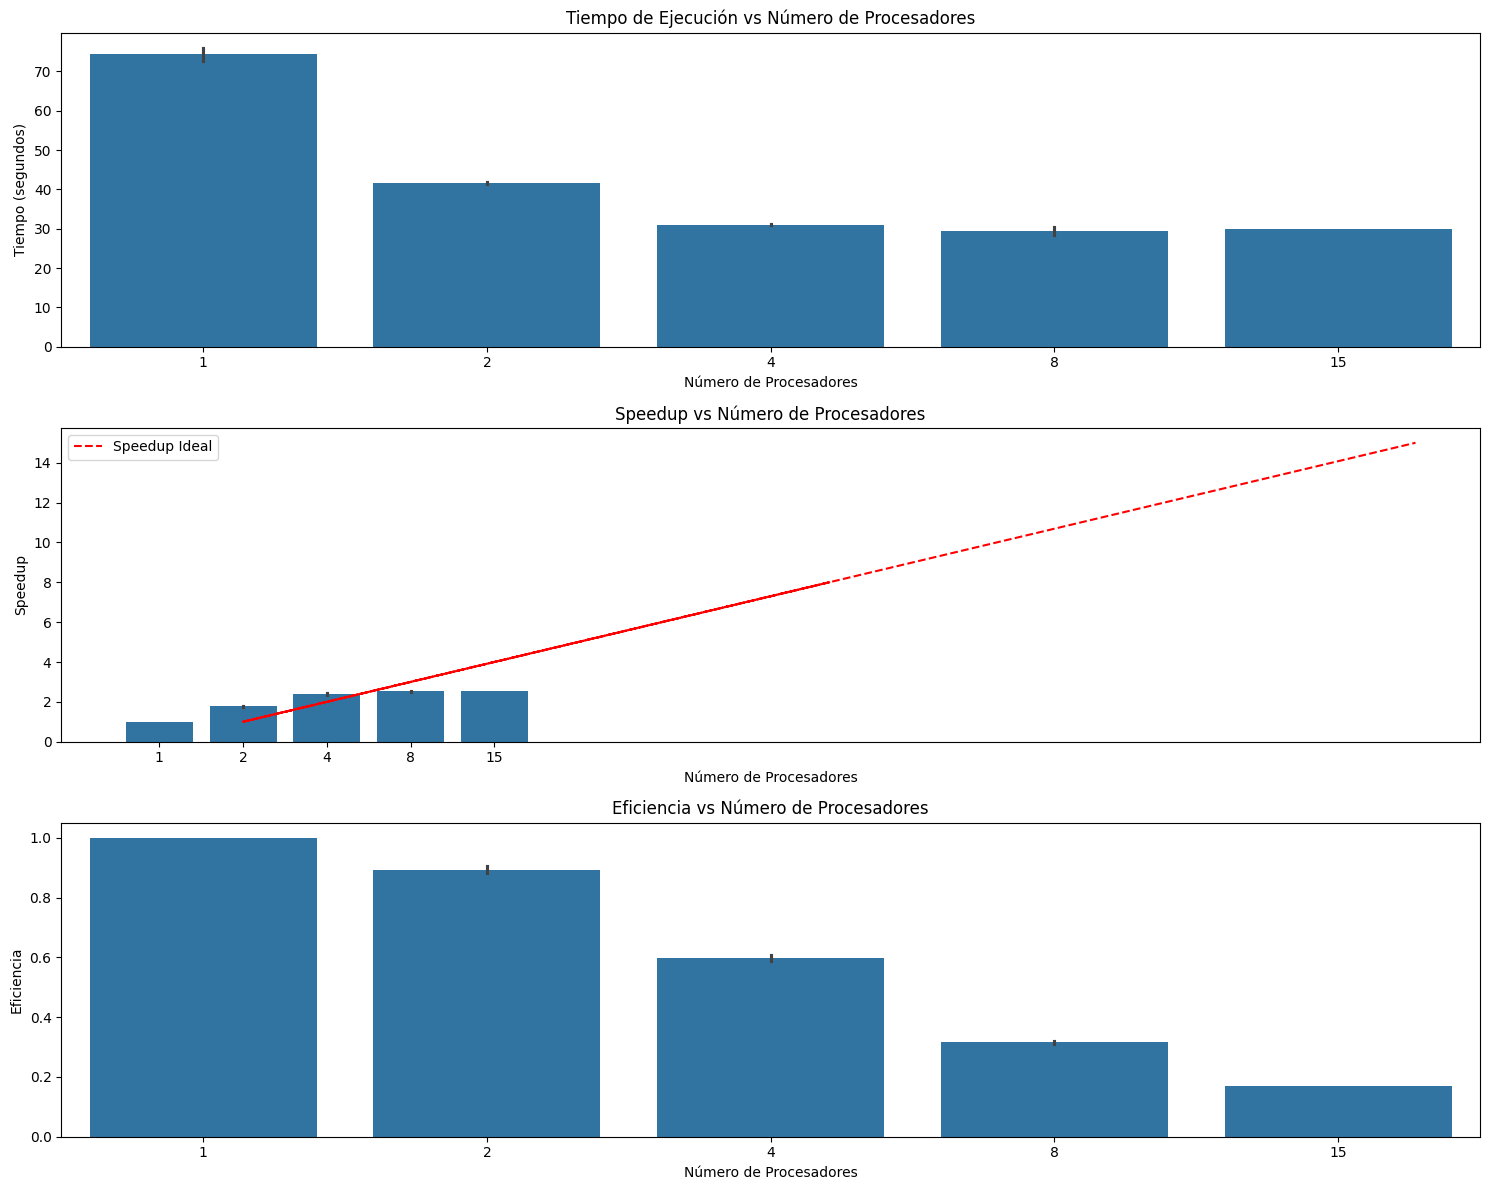

In [9]:
results_df = pd.DataFrame(results_data)
print("\nResults summary:")
print(results_df)

plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
sns.barplot(x='n_procesors', y='execution_time', data=results_df)
plt.title('Tiempo de Ejecución vs Número de Procesadores')
plt.xlabel('Número de Procesadores')
plt.ylabel('Tiempo (segundos)')

plt.subplot(3, 1, 2)
sns.barplot(x='n_procesors', y='speedup', data=results_df)
plt.title('Speedup vs Número de Procesadores')
plt.xlabel('Número de Procesadores')
plt.ylabel('Speedup')

x = np.array(results_df['n_procesors'])
y_ideal = x 
plt.plot(x, y_ideal, 'r--', label='Speedup Ideal')
plt.legend()

plt.subplot(3, 1, 3)
sns.barplot(x='n_procesors', y='efficiency', data=results_df)
plt.title('Eficiencia vs Número de Procesadores')
plt.xlabel('Número de Procesadores')
plt.ylabel('Eficiencia')

plt.tight_layout()
plt.savefig('performance_metrics.png')
plt.show()